# Example using pretrained ResNet 50-layer model

In [13]:
import os, urllib
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
def get_model(prefix, epoch):
    download(prefix+'-symbol.json')
    download(prefix+'-%04d.params' % (epoch,))

get_model('http://data.mxnet.io/models/imagenet/resnet/50-layers/resnet-50', 0)

In [14]:
import mxnet as mx
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-50', 0)

Both argument parameters and auxiliary parameters (e.g mean/std in batch normalization layer) are stored as a dictionary of string name and ndarray value (see ndarray.ipynb). The arguments contain consist of weight and bias.

In [15]:
#arg_params

## Extract Features
Sometime we want the internal outputs from a neural network rather than then final predicted probabilities. In this way, the neural network works as a feature extraction module to other applications.

A loaded symbol in default only returns the last layer as output. But we can get all internal layers by get_internals, which returns a new symbol outputting all internal layers. The following codes print the last 10 layer names.

We can also use mx.viz.plot_network(sym) to visually find the name of the layer we want to use. The name conventions of the output is the layer name with _output as the postfix.

In [16]:
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:-1]

['bn1_moving_var',
 'bn1_output',
 'relu1_output',
 'pool1_output',
 'flatten0_output',
 'fc1_weight',
 'fc1_bias',
 'fc1_output',
 'softmax_label']

Often we want to use the output before the last fully connected layers, which may return semantic features of the raw images but not too fitting to the label yet. In the ResNet case, it is the flatten layer with name flatten0 before the last fullc layer. The following codes get the new symbol sym3 which use the flatten layer as the last output layer, and initialize a new module.


In [17]:
all_layers = sym.get_internals()
sym3 = all_layers['flatten0_output']
mod3 = mx.mod.Module(symbol=sym3, label_names=None, context=mx.cpu())
mod3.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
mod3.set_params(arg_params, aux_params)

## Prepare data

We first obtain the synset file, in which the i-th line contains the label for the i-th class.

In [18]:
import os.path

name = "synset.txt"
if not os.path.isfile(name):
    download('http://data.mxnet.io/models/imagenet/resnet/synset.txt')

with open('synset.txt') as f:
    synsets = [l.rstrip() for l in f]

We next download 1000 images for testing, which were not used for the training. 

In [19]:
import tarfile

name = "val_1000.tar"
if not os.path.isfile(name):
    download('http://data.mxnet.io/data/val_1000.tar')
    
if not os.path.isfile("val_1000/label"):
    tfile = tarfile.open('val_1000.tar')
    tfile.extractall()

with open('val_1000/label') as f:
    val_label = [int(l.split('\t')[0]) for l in f]

Visualize the first 8 images.

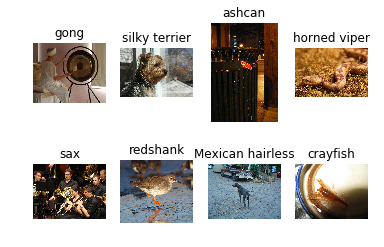

In [20]:
%matplotlib inline
import matplotlib
matplotlib.rc("savefig", dpi=100)
import matplotlib.pyplot as plt
import cv2
for i in range(0,8):
    img = cv2.cvtColor(cv2.imread('val_1000/%d.jpg' % (i,)), cv2.COLOR_BGR2RGB)
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.axis('off')
    label = synsets[val_label[i]]
    label = ' '.join(label.split(',')[0].split(' ')[1:])
    plt.title(label)

Next we define a function that reads one image each time and convert to a format can be used by the model. Here we use a naive way that resizes the original image into the desired shape, and change the data layout. 

In [21]:
import numpy as np
import cv2
def get_image(filename):
    img = cv2.imread(filename)  # read image in b,g,r order
    #img = cv2.cvColor(img, cv2.COLOR_BGR2RGB)   # change to r,g,b order
    img = cv2.resize(img, (224, 224))  # resize to 224*224 to fit model
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)  # change to (channel, height, width)
    img = img[np.newaxis, :]  # extend to (example, channel, heigth, width)
    return img

Finally we define a input data structure which is acceptable by mxnet. The field `data` is used for the input data, which is a list of NDArrays. 

In [22]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

Now we can do feature extraction using forward1 as before. Notice that the last convolution layer uses 2048 channels, and we then perform an average pooling, so the output size of the flatten layer is 2048.



In [23]:
# define 
img = get_image('val_1000/1.jpg')

In [24]:
mod3.forward(Batch([mx.nd.array(img)]))
out = mod3.get_outputs()[0].asnumpy()
print(out.shape)
out

(1, 2048)


array([[ 0.15950908,  0.        ,  1.00347674, ...,  0.80141163,
         0.63034654,  0.18145491]], dtype=float32)

## Add a new output layer with new classes

Set context.

In [25]:
from mxnet import nd, autograd, gluon

ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()
data_ctx = ctx
model_ctx = ctx

Allocate parameters for the output layer.

In [ ]:
#######################
#  Allocate parameters for the output layer
#######################
num_input = 2048
num_outputs = 2
weight_scale = .01

Wlast = nd.random_normal(shape=(num_input, num_outputs), scale=weight_scale, ctx=model_ctx)
blast = nd.random_normal(shape=num_input, scale=weight_scale, ctx=model_ctx)

params = [Wlast, blast]

In [4]:
def naic(cnn_feature_vector):
    #let's apply the softmax later
    return cnn_feature_vector * Wlast + blast


In [33]:
kp = ["images/1.jpg", "images/2.jpg", "images/3.jpg", "images/4.jpg", "images/5.jpg", "images/6.jpg", "images/7.jpg", "images/8.jpg",
      "images/9.jpg", "images/10.jpg", "images/11.jpg", "images/12.jpg", "images/13.jpg", "images/14.jpg", "images/15.jpg",
      "images/16.jpg", "images/17.jpg", "val_1000/1.jpg", "val_1000/2.jpg", "val_1000/3.jpg", "val_1000/4.jpg",
     "val_1000/5.jpg", "val_1000/6.jpg", "val_1000/7.jpg", "val_1000/8.jpg", "val_1000/9.jpg", "val_1000/10.jpg", 
     "val_1000/11.jpg", "val_1000/12.jpg", "val_1000/13.jpg", "val_1000/14.jpg", "val_1000/15.jpg", "val_1000/16.jpg",
     "val_1000/17.jpg"]

In [34]:
dataset_kp = []

In [35]:
for image in kp:
    img = get_image(image)
    mod3.forward(Batch([mx.nd.array(img)]))
    out = mod3.get_outputs()[0].asnumpy()
    dataset_kp.append(out)

# Karjalanpiirakka dataset:
17 images of kp

17 images of other classes from imagenet

data: output of the pre-last layer of pretrained CNN -> dataset_kp

In [127]:
typicality = np.asarray([2, 1, 1, 2, 3, 3, 2, 4, 3, 3, 2, 3, 2, 3, 5, 4, 3])
typicality_for_zero = np.repeat(np.mean(typicality), 17)
t_data = np.concatenate((typicality, typicality_for_zero), axis = 0)
labels = np.concatenate((np.repeat(1,17), np.repeat(0,17)))
labels = np.array([labels,t_data])

In [48]:
dataset_kp = np.array(dataset_kp)

In [36]:
from mxnet import nd, autograd, gluon


ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()
data_ctx = ctx
model_ctx = ctx

In [279]:
#######################
#  Allocate parameters for the output layer
#######################
num_input = 2048
num_outputs = 2
weight_scale = .01

Wlast = nd.random_normal(shape=(num_input, num_outputs), scale=weight_scale, ctx=model_ctx)
blast = nd.random_normal(shape=num_outputs, scale=weight_scale, ctx=model_ctx)

params = [Wlast, blast]

In [280]:
for param in params:
    param.attach_grad()

In [281]:
epochs = 10
learning_rate = 0.01
smoothing_constant = .01

for e in range(epochs):
    cumulative_loss = 0
    for i in range(len(dataset_kp) - 1):
        #data = data.as_in_context(model_ctx).reshape((-1, 784))
        #label = label.as_in_context(model_ctx)
        #label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = naic(nd.array(dataset_kp[i][0]))
            print(output)
            loss = softmax_cross_entropy(output, nd.array([labels[0][i], labels[1][i]]))
            print(output)
            print(loss)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()
    print(params[0:5])


    #test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate(labels)
    #print(e)
    #print(cumulative_loss/len(dataset_kp))
    print(train_accuracy)
    #print("Epoch %s. Loss: %s, Train_acc %s,"
    #      (e, cumulative_loss/len(dataset_kp), train_accuracy))


[-0.30694771 -0.0277824 ]
<NDArray 2 @cpu(0)>

[[ 1.          1.3220259 ]
 [ 0.75641483  1.        ]]
<NDArray 2x2 @cpu(0)>


IndexError: index 2 is out of bounds for axis 0 with size 2

In [306]:
def cross_entropy(yhat, y):
    return - nd.nansum(y * nd.log(yhat), axis=0, exclude=True)

def softmax_cross_entropy(yhat_linear, y):
    print(softmax(yhat_linear))
    return - (y[1]/y[0] * softmax(yhat_linear[1]) + (1-y[1])/y[0] * softmax(yhat_linear[0]))

In [307]:
def softmax(y_linear):
    exp = nd.exp(y_linear)
    partition = exp/nd.nansum(exp)
    return partition

In [250]:
def evaluate(y):
    pred = []
    for i in range(len(y[1])):
        out = naic(nd.array(dataset_kp[i][0]))
        pred.append(nd.argmax(out, axis = 0))
    error = np.mean(y[0] == pred)
    return error

In [308]:
output = naic(nd.array(dataset_kp[1][0]))
softmax_cross_entropy(output, nd.array([labels[0][5], labels[1][5]]))


[ 0.42599386  0.57400614]
<NDArray 2 @cpu(0)>



[-1.]
<NDArray 1 @cpu(0)>

In [156]:
def naic(cnn_feature_vector):
    #let's apply the softmax later
    return nd.dot(cnn_feature_vector,Wlast) + blast

In [291]:
import math

In [292]:
math.exp(3.2)

24.532530197109352

In [299]:
softmax(a)


[  4.48168898  24.53253174]
<NDArray 2 @cpu(0)>



[ 0.15446526  0.84553474]
<NDArray 2 @cpu(0)>

In [294]:
a = nd.array([1.5, 3.2])


In [288]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [155]:
naic(nd.array(dataset_kp[1][0]))


[ 0.06538776 -0.2593925 ]
<NDArray 2 @cpu(0)>



[ 0.06287518 -0.26407158]
<NDArray 2 @cpu(0)>

In [54]:
len(dataset_kp)

34

In [ ]:
Wlast

In [108]:
nd.dot(nd.array(dataset_kp[1][0]),Wlast) + blast

MXNetError: [18:45:33] c:\jenkins\workspace\mxnet-tag\mxnet\src\operator\tensor\./elemwise_binary_broadcast_op.h:68: Check failed: l == 1 || r == 1 operands could not be broadcast together with shapes [2] [2048]

In [111]:
nd.dot(nd.array(dataset_kp[1][0]),Wlast)


[-0.36279893  0.38253623]
<NDArray 2 @cpu(0)>

In [112]:
blast


[ 0.00403653  0.00605313 -0.0088165  ...,  0.00961348  0.01918563
 -0.00291194]
<NDArray 2048 @cpu(0)>